## Dense fully connected MLP example

In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import cv2
import skimage
from skimage import transform
from skimage.transform import resize
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

Using TensorFlow backend.


In [6]:
# MLP
#--------------------------------------------------------------#
# dimensions of our images.
img_width, img_height = 256, 256
categories = 4

# define directories and parameters
train_data_dir = 'data/train'
test_data_dir = 'data/test'
validation_data_dir = 'data/validation'

# number of samples used for determining the samples_per_epoch
nb_train_samples = 83484
nb_validation_samples = 968
epochs = 5
batch_size = 128
#--------------------------------------------------------------#
# fix data format issues
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# data augmentation for reducing overfitting
datagen = ImageDataGenerator(
        rescale=1./255,            
        shear_range=0.2,      
        zoom_range=0.2,    
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True) 

# data generator for test set
test_datagen = ImageDataGenerator(rescale = 1./255)

# generator for reading train data from folder
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    #color_mode = 'rgb',
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

# generator for reading validation data from folder
# set shuffle=False for generator_predict/ generator.reset()
validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    #color_mode = 'rgb'
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False)

# generator for reading test data from folder
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size = 1,
    class_mode = None,
    shuffle = False)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 1 classes.


In [3]:
print('train labels: ', train_generator.class_indices)
print('validation labels: ', validation_generator.class_indices)
print('test labels: ', test_generator.class_indices)

train labels:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
validation labels:  {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
test labels:  {'test': 0}


In [20]:
map_characters = validation_generator.class_indices
print(map_characters)

labels = map_characters

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [4]:
# Build mlp
# for custom metrics
import keras.backend as K

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(categories, activation="softmax"))
    
# Compile the model
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy", mean_pred])

print("MLP Structure:")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
MLP Structure:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               100663808 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 100,665,860
Trainable params: 100,665,860
Non-trainable params: 0
_________________________________________________________________


In [8]:
# FIT GENERATOR
history = model.fit_generator(
        train_generator,
        steps_per_epoch = nb_train_samples // batch_size,
        epochs = 1, #epochs,
        verbose = 1,
        validation_data = validation_generator,
        validation_steps = nb_validation_samples // batch_size)

# save weights
model.save_weights('keras_mlp.h5')
# Save the model architecture
with open('mlp_arch.json', 'w') as f:
    f.write(model.to_json())

Epoch 1/1
652/652 [==============================] - 1002s 2s/step - loss: 8.9326 - acc: 0.4458 - mean_pred: 0.2500 - val_loss: 11.7648 - val_acc: 0.2701 - val_mean_pred: 0.2500


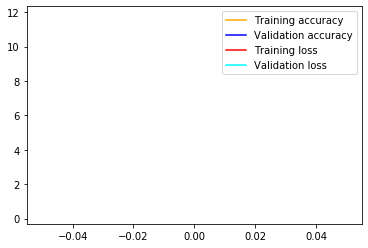

In [9]:
#--------------#
# plot acc and loss one plot
#--------------#
plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'cyan', label='Validation loss')
plt.legend()
plt.show()

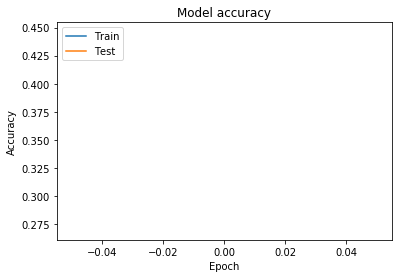

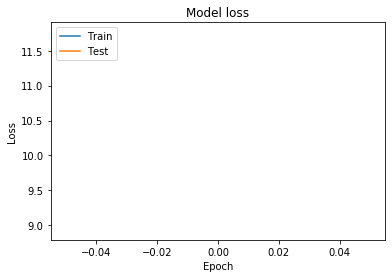

In [10]:
#--------------#
# plot acc and loss two plot
#--------------#
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
#--------------#
# evaulate model metrics
#--------------#

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# evaluate generator accuracy score and print
model_score = model.evaluate_generator(
    generator=validation_generator,
    steps=nb_validation_samples // batch_size)

print("%s: %.2f%%" % (model.metrics_names[1], model_score[1]*100))

# reset validation generator
validation_generator.reset()

acc: 28.81%


In [17]:
#--------------#
# Confution Matrix and Classification Report
#--------------#
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

# classification report
print('Classification Report')
target_names = ['NORMAL', 'CNV', 'DME', 'DRUSEN'] # labels
print(classification_report(
    validation_generator.classes, 
    y_pred, 
    target_names=target_names))

#--------------#
# call plt confusion matrix
#--------------#
# plt.style.use('seaborn-white')
#confusion_mtx = confusion_matrix(y_true, y_pred) 
#plot_confusion_matrix(confusion_mtx, classes=labels)
#plt.show()

Confusion Matrix
[[242   0   0   0]
 [242   0   0   0]
 [242   0   0   0]
 [242   0   0   0]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.25      1.00      0.40       242
         CNV       0.00      0.00      0.00       242
         DME       0.00      0.00      0.00       242
      DRUSEN       0.00      0.00      0.00       242

    accuracy                           0.25       968
   macro avg       0.06      0.25      0.10       968
weighted avg       0.06      0.25      0.10       968



[0] [[1. 0. 0. 0.]]
{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}
<class 'PIL.Image.Image'>
None
RGB
(256, 256)


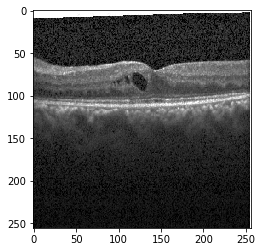

In [22]:
#--------------#
# single image predict and report 
#--------------#
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from IPython.display import Image

test_model = model

img = load_img('data/test/test/DME-9721607-2.jpeg', target_size=(img_width,img_height))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
preds = test_model.predict_classes(x)
prob = test_model.predict_proba(x)
print(preds, prob)
# report details about the image
print(labels)
print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
plt.imshow(img)
# img.show()  # output to local image preview

In [23]:
# predict output test generator
steps_test = test_generator.n // test_generator.batch_size
test_generator.reset()
pred = model.predict_generator(
    test_generator,
    steps=steps_test,
    verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Save to CSV
filenames = test_generator.filenames
results = pd.DataFrame({'Filename':filenames,
                      'Predictions':predictions})
results.to_csv('results_mlp.csv', index=False)

# load CSV and print
df_results = pd.read_csv('results_mlp.csv')
print(df_results)

32/32 [==============================] - 0s 4ms/step
                      Filename Predictions
0      test\CNV-6294785-1.jpeg         CNV
1      test\CNV-6294785-2.jpeg         CNV
2      test\CNV-6652117-1.jpeg         CNV
3      test\CNV-6668596-1.jpeg         CNV
4      test\CNV-6851127-1.jpeg         CNV
5      test\CNV-6875371-1.jpeg         CNV
6      test\CNV-8184974-1.jpeg         CNV
7      test\CNV-8598714-1.jpeg         CNV
8      test\DME-9583225-1.jpeg         CNV
9      test\DME-9583225-2.jpeg         CNV
10     test\DME-9603124-1.jpeg         CNV
11     test\DME-9655949-1.jpeg         CNV
12     test\DME-9721607-1.jpeg         CNV
13     test\DME-9721607-2.jpeg         CNV
14     test\DME-9925591-1.jpeg         CNV
15     test\DME-9925591-2.jpeg         CNV
16  test\DRUSEN-9800172-2.jpeg         CNV
17  test\DRUSEN-9837663-1.jpeg         CNV
18  test\DRUSEN-9861332-1.jpeg         CNV
19  test\DRUSEN-9884539-1.jpeg         CNV
20  test\DRUSEN-9884539-2.jpeg         CNV
2